<a href="https://colab.research.google.com/github/pranaya-mathur/Deep-Learning-Projects/blob/master/Image_Segmentation_U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import zipfile
zip_ref = zipfile.ZipFile("U-NET.zip", 'r')
zip_ref.extractall("U_NET")
zip_ref.close()

In [0]:
import os
import sys
import random
import warnings #
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import tensorflow as tf

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = 'U_NET/U_NET/train/'
TEST_PATH = 'U_NET/U_NET/validation/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [0]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [22]:
train_ids[:5]

['0d3640c1f1b80f24e94cc9a5f3e1d9e8db7bf6af7d4aba920265f46cadc25e37',
 'd827a7d80fc67487a3237135e0d43ae01b7bbcb135e1a167601fc974a8348c51',
 '6bc8cda54f5b66a2a27d962ac219f8075bf7cc43b87ba0c9e776404370429e80',
 '1740b0a67ca337ea31648b57c81bcfbb841c7bb5cad185199a9f4da596d531b9',
 '03f583ec5018739f4abb9b3b4a580ac43bd933c4337ad8877aa18b1dfb59fc9a']

In [23]:
test_ids[:5]

['a4816cc1fb76cb3c5e481186833fc0ae9cf426a1406a2607e974e65e9cddba4f',
 'df40099c6306ca1f47fcc8a62e2fa39486d4e223177afdc51b2ad189691802d8',
 '51c70bb8a299943b27f8b354571272692d8f2705036a1a9562156c76da5f025b',
 '31f1fbe85b8899258ea5bcf5f93f7ac8238660c386aeab40649c715bd2e38a0a',
 '550450e4bff4036fd671decdc5d42fec23578198d6a2fd79179c4368b9d6da18']

In [25]:
print('Getting and resizing training images ... ')
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        
# Re-sizing our training images to 128 x 128
# Note sys.stdout prints info that can be cleared unlike print.
# Using TQDM allows us to create progress bars
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    
    # Now we take all masks associated with that image and combine them into one single mask
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    # Y_train is now our single mask associated with our image
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()

# Here we resize our test images
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing training images ... 


100%|██████████| 670/670 [07:25<00:00,  1.04it/s]

Getting and resizing test images ... 



100%|██████████| 65/65 [00:02<00:00, 30.32it/s]

Done!


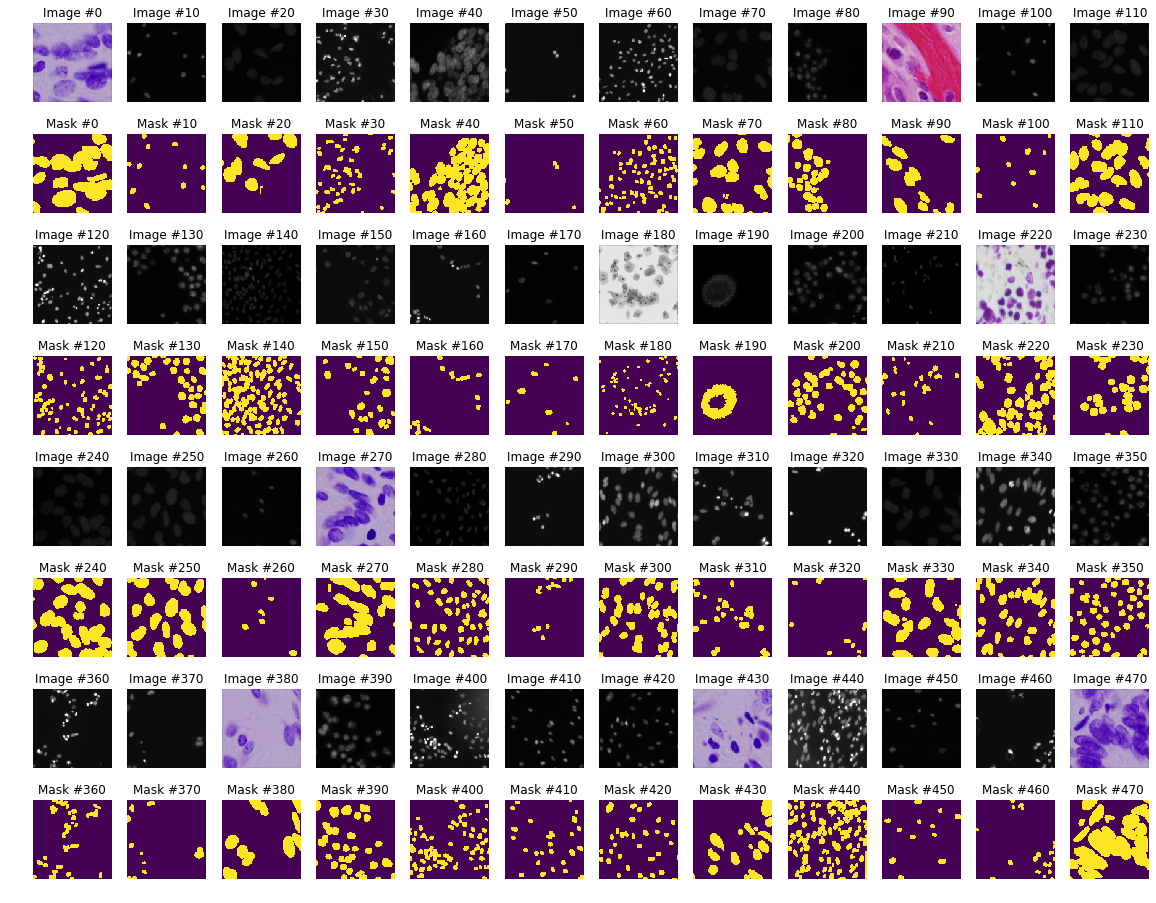

In [26]:
# Illustrate the train images and masks
plt.figure(figsize=(20,16))
x, y = 12,4
for i in range(y):  
    for j in range(x):
        plt.subplot(y*2, x, i*2*x+j+1)
        pos = i*120 + j*10
        plt.imshow(X_train[pos])
        plt.title('Image #{}'.format(pos))
        plt.axis('off')
        plt.subplot(y*2, x, (i*2+1)*x+j+1)
        
        #We display the associated mask we just generated above with the training image
        plt.imshow(np.squeeze(Y_train[pos]))
        plt.title('Mask #{}'.format(pos))
        plt.axis('off')
        
plt.show()

In [0]:
def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.array(np.mean(metric), dtype=np.float32)

def my_iou_metric(label, pred):
    metric_value = tf.py_func(iou_metric_batch, [label, pred], tf.float32)
    return metric_value

![alt text](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [34]:
# Build U-Net model
# Note we make our layers varaibles so that we can concatenate or stack
# This is required so that we can re-create our U-Net Model

inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

# Note our output is effectively a mask of 128 x 128 
outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[my_iou_metric])
model.summary()

W0704 06:50:19.621090 140593157814144 deprecation.py:323] From <ipython-input-33-b8ee816b3b8a>:10: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 128, 128, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 128, 128, 16) 448         lambda_4[0][0]                   
__________________________________________________________________________________________________
dropout_28 (Dropout)            (None, 128, 128, 16) 0           conv2d_58[0][0]                  
__________________________________________________________________________________________________
conv2d_59 

In [35]:
# Initialize our callbacks
model_path = "nuclie_finder.h5"
checkpoint = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True)

# Fit our model 
results = model.fit(X_train, Y_train, validation_split=0.1,
                    batch_size=16, epochs=10, 
                    callbacks=[earlystop, checkpoint])

Train on 603 samples, validate on 67 samples
Epoch 1/10
603/603 [==============================] - 14s 23ms/step - loss: 0.4706 - my_iou_metric: 0.0132 - val_loss: 0.4009 - val_my_iou_metric: 0.1515

Epoch 00001: val_loss improved from inf to 0.40086, saving model to nuclie_finder.h5
Epoch 2/10
603/603 [==============================] - 5s 8ms/step - loss: 0.2074 - my_iou_metric: 0.2249 - val_loss: 0.1885 - val_my_iou_metric: 0.2920

Epoch 00002: val_loss improved from 0.40086 to 0.18853, saving model to nuclie_finder.h5
Epoch 3/10
603/603 [==============================] - 5s 8ms/step - loss: 0.1453 - my_iou_metric: 0.3690 - val_loss: 0.1270 - val_my_iou_metric: 0.3722

Epoch 00003: val_loss improved from 0.18853 to 0.12704, saving model to nuclie_finder.h5
Epoch 4/10
603/603 [==============================] - 5s 8ms/step - loss: 0.1317 - my_iou_metric: 0.4040 - val_loss: 0.1636 - val_my_iou_metric: 0.3643

Epoch 00004: val_loss did not improve from 0.12704
Epoch 5/10
603/603 [=======

In [37]:
# Predict on training and validation data
# Note our use of mean_iou metri
model = load_model('nuclie_finder.h5', 
                   custom_objects={'my_iou_metric': my_iou_metric})

# the first 90% was used for training
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)

# the last 10% used as validation
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)

#preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

67/67 [==============================] - 0s 2ms/step


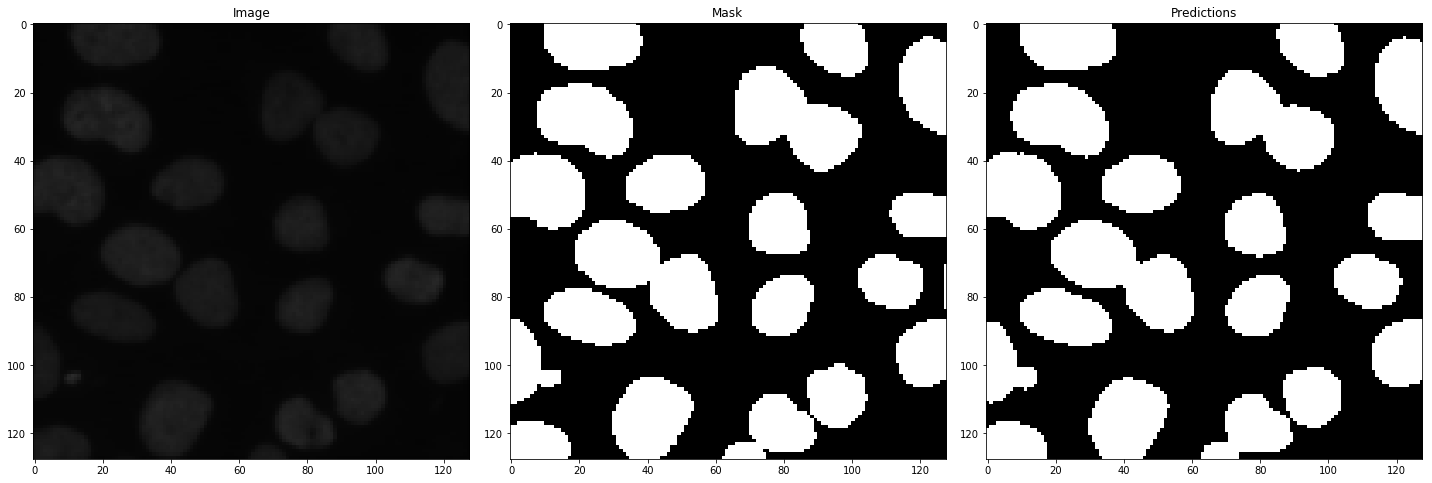

In [38]:
# Ploting our predicted masks
ix = random.randint(0, 602)
plt.figure(figsize=(20,20))

# Our original training image
plt.subplot(131)
imshow(X_train[ix])
plt.title("Image")

# Our original combined mask  
plt.subplot(132)
imshow(np.squeeze(Y_train[ix]))
plt.title("Mask")

# The mask our U-Net model predicts
plt.subplot(133)
imshow(np.squeeze(preds_train_t[ix] > 0.5))
plt.title("Predictions")
plt.show()

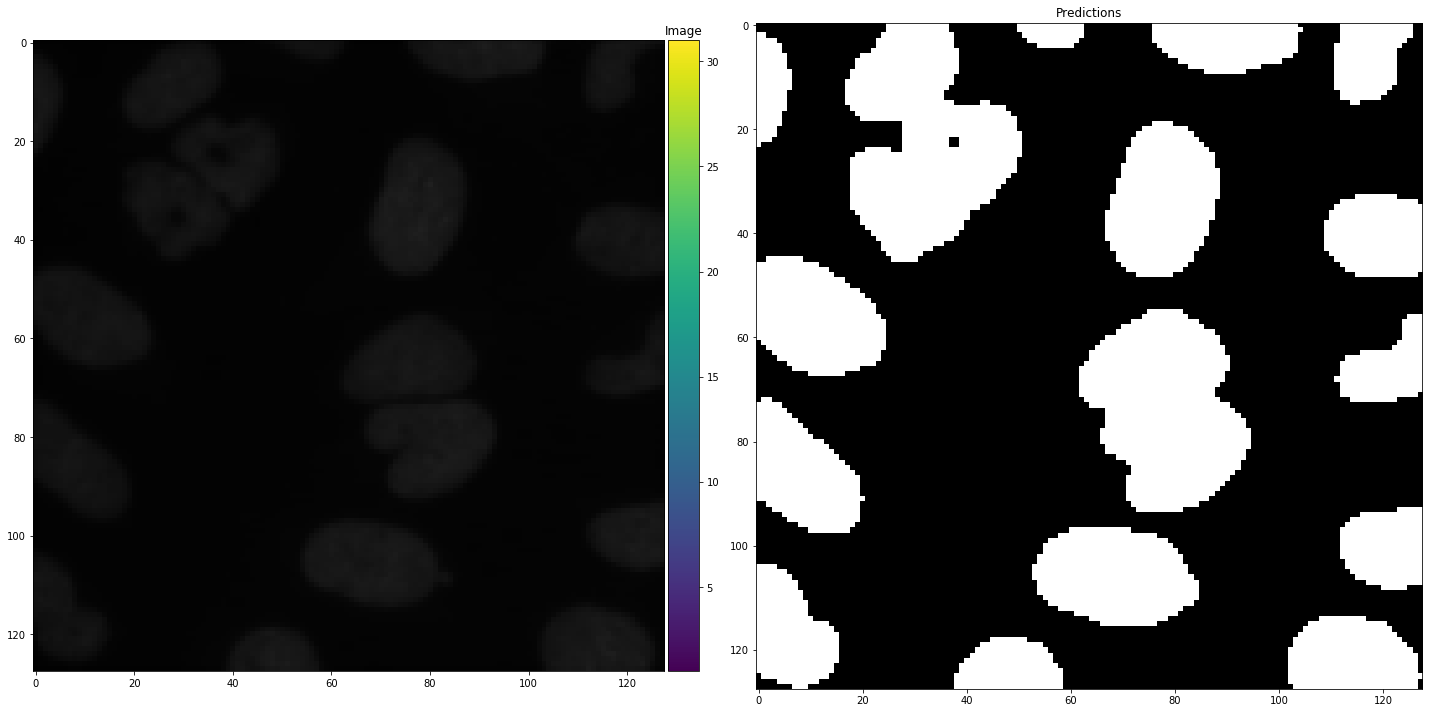

In [39]:
# Ploting our predicted masks
ix = random.randint(602, 668)
plt.figure(figsize=(20,20))

# Our original training image
plt.subplot(121)
imshow(X_train[ix])
plt.title("Image")

# The mask our U-Net model predicts
plt.subplot(122)
ix = ix - 603
imshow(np.squeeze(preds_val_t[ix] > 0.5))
plt.title("Predictions")
plt.show()